## Solving a model

`cobrapy` supports several methods for finding fluxes through a metabolic network

In [1]:
import cobra

# Plotting utilities
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks', color_codes=True)
%matplotlib inline

In [2]:
test_model = cobra.io.load_yaml_model('data/test_model.yaml')

### Objective function

Model objectives can be any arbitrary linear (or quadratic, for QP) combination of the variables in the problem.

For convenience, it is often preferable to specify an *objective reaction*, or a reaction through which flux should be maximized

In [3]:
test_model.reactions.atpm.reaction

'atp --> adp'

In [4]:
test_model.objective = test_model.reactions.atpm
test_model.optimize()

,fluxes,reduced_costs
EX_co2,60.0,0.0
EX_glc,-10.0,-12.0
GLCpts,10.0,0.0
atpm,60.0,0.0
lwg,20.0,0.0
upg,10.0,0.0


Several test models are available with the `cobrapy` suite, including `"textbook"`, `"ecoli"`, and `"salmonella"`

In [5]:
import cobra.test
model = cobra.test.create_test_model("textbook")
model

Name,e_coli_core
Memory address,0x0119b7a710
Number of metabolites,72
Number of reactions,95
Objective expression,-1.0*Biomass_Ecoli_core_reverse_2cdba + 1.0*Biomass_Ecoli_core
Compartments,"cytosol, extracellular"


In [6]:
solution = model.optimize()
# solution

### Summary methods
summary methods are a quick way to display useful information about the optimized fluxes in a model.

In [7]:
model.summary(solution)

IN FLUXES        OUT FLUXES    OBJECTIVES
---------------  ------------  ----------------------
o2_e      21.8   h2o_e  29.2   Biomass_Ecol...  0.874
glc__D_e  10     co2_e  22.8
nh4_e      4.77  h_e    17.5
pi_e       3.21


if no solution object is given, the model will be re-optimized in the current state

In [8]:
model.reactions.EX_co2_e.knock_out()

model.summary()

model.reactions.EX_co2_e.bounds = (-1000, 1000)

IN FLUXES        OUT FLUXES    OBJECTIVES
---------------  ------------  ----------------------
glc__D_e  10     h_e    37.5   Biomass_Ecol...  0.462
o2_e       7.48  for_e  16
nh4_e      2.52  ac_e   12.2
pi_e       1.7   h2o_e   3.36


Summaries can also be called on individual metabolite objects:

In [9]:
model.metabolites.pyr_c.summary()

PRODUCING REACTIONS -- Pyruvate (pyr_c)
---------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
85%   10     GLCpts      glc__D_e + pep_c --> g6p_c + pyr_c
15%    1.76  PYK         adp_c + h_c + pep_c --> atp_c + pyr_c

CONSUMING REACTIONS -- Pyruvate (pyr_c)
---------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
79%    9.28  PDH         coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
21%    2.48  Biomass...  1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0....


In [10]:
model.metabolites.atp_c.summary()

PRODUCING REACTIONS -- ATP (atp_c)
----------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
67%  45.5    ATPS4r      adp_c + 4.0 h_e + pi_c <=> atp_c + h2o_c + 3.0 h_c
23%  16      PGK         3pg_c + atp_c <=> 13dpg_c + adp_c
7%    5.06   SUCOAS      atp_c + coa_c + succ_c <=> adp_c + pi_c + succoa_c
3%    1.76   PYK         adp_c + h_c + pep_c --> atp_c + pyr_c

CONSUMING REACTIONS -- ATP (atp_c)
----------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
76%  52.3    Biomass...  1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0....
12%   8.39   ATPM        atp_c + h2o_c --> adp_c + h_c + pi_c
11%   7.48   PFK         atp_c + f6p_c --> adp_c + fdp_c + h_c
0%    0.223  GLNS        atp_c + glu__L_c + nh4_c --> adp_c + gln__L_c +...


### Inspecting and changing the model medium

A model's `medium` describes the bounds on the exchange reactions which allow flux into the cell. In `cobrapy`, this can be convieniently set through the `model.medium` property

In [11]:
model.medium

{'EX_co2_e': 1000,
 'EX_glc__D_e': 10.0,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0}

For anaerobic fermentation, we can remove the availability of oxygen

In [12]:
medium = model.medium
medium['EX_o2_e'] = 0
model.medium = medium
model.summary()

medium['EX_o2_e'] = 1000
model.medium = medium

IN FLUXES         OUT FLUXES     OBJECTIVES
----------------  -------------  ----------------------
glc__D_e  10      h_e     30.6   Biomass_Ecol...  0.212
h2o_e      7.12   for_e   17.8
nh4_e      1.15   ac_e     8.5
pi_e       0.779  etoh_e   8.28
co2_e      0.378


### Reversible changes to model properties with context managers

In the previous examples, we've been manually undoing changes to the model properties after each iteration. We can instead use the provided context managers to reversibly modify the model's state.

*Note:* This is significantly faster than duplicating the model via `model.copy()`

In [13]:
with model:
    model.reactions.PYK.knock_out()
    model.summary()

IN FLUXES        OUT FLUXES    OBJECTIVES
---------------  ------------  ----------------------
o2_e      22.2   h2o_e  29.5   Biomass_Ecol...  0.865
glc__D_e  10     co2_e  23.2
nh4_e      4.72  h_e    17.4
pi_e       3.18


In [14]:
model.reactions.PYK.bounds

(0.0, 1000.0)

These are also useful for in-the-loop modifications

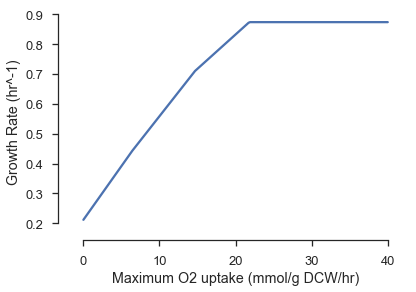

In [15]:
o2_bound = np.linspace(0, 40, 200)

growth_rates = []
for bound in o2_bound:
    with model:
        model.reactions.EX_o2_e.lower_bound = -bound
        growth_rates += [model.slim_optimize()]

plt.plot(o2_bound, growth_rates, '-')
plt.ylabel('Growth Rate (hr^-1)')
plt.xlabel('Maximum O2 uptake (mmol/g DCW/hr)')
sns.despine(trim=True, offset=10)

## Flux analysis methods

`cobrapy` includes a number of common optimization methods in addition to traditional FBA

### Parsimonius FBA
`pfba` minimizes the sum of absolute values of the individual fluxes in the model. This is an efficient technique which helps to alleviate the occurance of thermodynamically infeasible flux loops

In [16]:
solution = cobra.flux_analysis.pfba(model)
model.summary(solution)

IN FLUXES        OUT FLUXES    OBJECTIVES
---------------  ------------  ----------------------
o2_e      21.8   h2o_e  29.2   Biomass_Ecol...  0.874
glc__D_e  10     co2_e  22.8
nh4_e      4.77  h_e    17.5
pi_e       3.21


### Minimization of metabolic adjustment (MOMA)

MOMA seeks to find flux predictions for knock-out strains that are as close as possible to reference (wild-type) solution.

In [17]:
wt_solution = cobra.flux_analysis.pfba(model)
model.summary(wt_solution)

IN FLUXES        OUT FLUXES    OBJECTIVES
---------------  ------------  ----------------------
o2_e      21.8   h2o_e  29.2   Biomass_Ecol...  0.874
glc__D_e  10     co2_e  22.8
nh4_e      4.77  h_e    17.5
pi_e       3.21


In [18]:
with model:
    cobra.flux_analysis.moma.add_moma(model)
    model.reactions.TPI.knock_out()
    moma_solution = model.optimize()
    
model.summary(moma_solution)

IN FLUXES         OUT FLUXES    OBJECTIVES
----------------  ------------  ---------------------
o2_e      19.1    h2o_e  20.6   Biomass_Ecol...  0.17
glc__D_e   4.43   co2_e  19.3
nh4_e      0.927  h_e     3.41
pi_e       0.625


In [19]:
model.metabolites.g3p_c.summary(wt_solution)

PRODUCING REACTIONS -- Glyceraldehyde 3-phosphate (g3p_c)
---------------------------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
42%   7.48   FBA         fdp_c <=> dhap_c + g3p_c
42%   7.48   TPI         dhap_c <=> g3p_c
8%    1.5    TKT1        r5p_c + xu5p__D_c <=> g3p_c + s7p_c
7%    1.18   TKT2        e4p_c + xu5p__D_c <=> f6p_c + g3p_c

CONSUMING REACTIONS -- Glyceraldehyde 3-phosphate (g3p_c)
---------------------------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
91%  16      GAPD        g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
8%    1.5    TALA        g3p_c + s7p_c <=> e4p_c + f6p_c
1%    0.113  Biomass...  1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0....


In [20]:
model.metabolites.g3p_c.summary(moma_solution)

PRODUCING REACTIONS -- Glyceraldehyde 3-phosphate (g3p_c)
---------------------------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
50%  4.23    TKT1        r5p_c + xu5p__D_c <=> g3p_c + s7p_c
50%  4.17    TKT2        e4p_c + xu5p__D_c <=> f6p_c + g3p_c

CONSUMING REACTIONS -- Glyceraldehyde 3-phosphate (g3p_c)
---------------------------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
50%  4.23    TALA        g3p_c + s7p_c <=> e4p_c + f6p_c
49%  4.14    GAPD        g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
0%   0.0219  Biomass...  1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0....


### Flux variability analysis (FVA)

Flux variability analysis (FVA) quantifies the ranges of flux that are possible through each reaction while holding the model's objective value at a fixed percentage of its maximum.

This technique is useful for identifying feasible regions of flux, or assessing the identifiability of different reactions from experimental data.

In [21]:
fva_results = cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=0.95)
fva_results.head()

,maximum,minimum
ACALD,1.678434e-17,-1.271185
ACALDt,0.000000e+00,-1.271185
ACKr,0.000000e+00,-1.906778
ACONTa,8.277549e+00,1.687833
ACONTb,8.277549e+00,1.687833


Flux variability methods are also available from within the summary methods

In [22]:
model.summary(fva=0.95)

IN FLUXES                       OUT FLUXES                      OBJECTIVES
------------------------------  ------------------------------  ----------------------
id          Flux  Range         id          Flux  Range         Biomass_Ecol...  0.874
--------  ------  ------------  --------  ------  ------------
o2_e       21.8   [19.9, 23.7]  h2o_e       29.2  [25, 30.7]
glc__D_e   10     [9.52, 10]    co2_e       22.8  [18.9, 24.7]
nh4_e       4.77  [4.53, 5.16]  h_e         17.5  [16.7, 22.4]
pi_e        3.21  [3.05, 3.21]  for_e        0    [0, 5.72]
                                ac_e         0    [0, 1.91]
                                acald_e      0    [0, 1.27]
                                pyr_e        0    [0, 1.27]
                                etoh_e       0    [0, 1.11]
                                lac__D_e     0    [0, 1.07]
                                succ_e       0    [0, 0.837]
                                akg_e        0    [0, 0.715]
                   

In [23]:
model.metabolites.atp_c.summary(fva=0.95)

PRODUCING REACTIONS -- ATP (atp_c)
----------------------------------
%      FLUX  RANGE          RXN ID      REACTION
---  ------  -------------  ----------  ----------------------------------------
67%  45.5    [38.5, 53.8]   ATPS4r      adp_c + 4.0 h_e + pi_c <=> atp_c + h2...
23%  16      [11.2, 17.8]   PGK         3pg_c + atp_c <=> 13dpg_c + adp_c
7%    5.06   [0, 7.38]      SUCOAS      atp_c + coa_c + succ_c <=> adp_c + pi...
3%    1.76   [0, 12.3]      PYK         adp_c + h_c + pep_c --> atp_c + pyr_c
0%    0      [0, 1.91]      ACKr        ac_c + atp_c <=> actp_c + adp_c

CONSUMING REACTIONS -- ATP (atp_c)
----------------------------------
%      FLUX  RANGE          RXN ID      REACTION
---  ------  -------------  ----------  ----------------------------------------
76%  52.3    [49.7, 52.3]   Biomass...  1.496 3pg_c + 3.7478 accoa_c + 59.81 ...
12%   8.39   [8.39, 17]     ATPM        atp_c + h2o_c --> adp_c + h_c + pi_c
11%   7.48   [2.58, 16.4]   PFK         atp_c + f6p_c -

### Custom bounds and objectives

`cobrapy` relies on the [optlang](https://github.com/biosustain/optlang) backend to provide solver support. Therefore, arbitrary objectives and constraints can be added using the optlang interface

In [24]:
same_flux = model.problem.Constraint(
    model.reactions.FBA.flux_expression - model.reactions.NH4t.flux_expression,
    lb=0, ub=0)

# Variables and constraints can be added reversibly using the context manager
with model:   
    model.add_cons_vars(same_flux)
    model.summary()

IN FLUXES        OUT FLUXES    OBJECTIVES
---------------  ------------  ----------------------
o2_e      22.6   h2o_e  29.8   Biomass_Ecol...  0.855
glc__D_e  10     co2_e  23.6
nh4_e      4.66  h_e    17.2
pi_e       3.15


Slightly more complicated, ensure that all fluxes in the model have a non-negative absolute flux while minimizing the squared difference between the WT solution and the new solution

In [25]:
qp_obj = -sum([(reaction.flux_expression - wt_solution[reaction.id])**2
               for reaction in model.reactions])

with model:
    
    for rxn in model.exchanges:
        rxn.bounds = (-1000, 1000)

    model.solver = 'cplex'
    model.objective = qp_obj

    for reaction in model.reactions:
        indicator = model.problem.Variable("b_" + reaction.id, type="binary")
        
        neg_constraint = model.problem.Constraint(
            reaction.flux_expression + 2000 * indicator,
            lb=0.1,
            name=reaction.id + "_neg_const")
        pos_constraint = model.problem.Constraint(
            -reaction.flux_expression + 2000 * (1 - indicator),
            lb=0.1,
            name=reaction.id + "_pos_const")

        model.add_cons_vars([neg_constraint, pos_constraint, indicator])
        
    solution = model.optimize()

In [26]:
solution.fluxes.abs().min()

0.099999999000022738